# Natural Language processing (NLP) for Processing with Disaster Tweets

In this notebook, we are going to organize the text data that is part of this kaggle dataset related to disaster events in text format, prepare different models and evaluate their efficiency.

First, we check that the GPU is available.

In [20]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2070 with Max-Q Design (UUID: GPU-a3f27b1a-181b-799c-9292-aeaeb3b7b8ed)


In [1]:
# Import tensorflow and confirm the GPU availability.
import tensorflow as tf
tf.config.set_soft_device_placement(True)
print(tf.config.list_physical_devices('GPU'))
print(f"TensorFlow version: {tf.__version__}")

2025-02-25 10:33:54.276133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740472434.374942     677 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740472434.407718     677 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 10:33:54.716155: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.18.0


I will also import the library file where I have been storing commonly used functions for tensorflow and for data representation:

In [2]:
import sys
import os

sys.path.append(os.path.abspath("../lib"))

In [3]:
import importlib
import modelgraph
importlib.reload(modelgraph)  # Reload it after changes

<module 'modelgraph' from '/home/david/VSpython/Git/lib/modelgraph.py'>

## Importing and visualizing the data

The dataset we are working with in this notebook is obtained from [Kaggle's NLP with disaster tweets](https://www.kaggle.com/competitions/nlp-getting-started/data). Fom the folder, we have a train.csv file and a test.csv file.

In [4]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_dir = "../Sources/nlp_disasters/train.csv"
test_dir = "../Sources/nlp_disasters/test.csv"
train_df = pd.read_csv(train_dir)
test_df = pd.read_csv(test_dir)
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


We can shuffle to see a better representation of the data, as we notice there are some columns with empty values. Just to have a glimpse to what other groups of data can show.

In [5]:

# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=10) # shuffle with random_state=10 for reproducibility
train_df_shuffled.head() 

,id,keyword,location,text,target
6524,9332,survive,NaN,@DDNewsLive @NitishKumar and @ArvindKejriwal ...,0
701,1009,blazing,NaN,@ACOUSTICMALOLEY no he was blazing it,0
3119,4479,electrocuted,"Redondo Beach, CA",Do babies actually get electrocuted from wall ...,1
4204,5972,hazard,Massachusetts,Precious cargo onesie recalled for choking haz...,0
1651,2386,collapsed,NaN,My portable closet has collapsed 3x and it fin...,0


We see some words could trigger our model as they could be used in a disastrous event. But the context is what would make us decide if it is an actual bad situation or not. As a confirmation, we have `target`.  

In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


For our test data, target is what we would need to figure out if it is related to a disastruous situation or not.

Let's further examine the training dataset. How many actual disastrous event messages we have, and how many regular o non important messages do we have?

Using  `value_counts` we see we have 4342 non-important event and 3271 diaster event messages.
We have also 3263 messages for testing.

In [7]:
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [8]:
len(test_df)

3263

As we have done before in our vision projects, it is positive to watch some examples to have a better idea of the type of data we are handling. In my opinion, the location gives us little information for this topic, so for now let's see the other fields.

In [9]:
import random
random_index = random.randint(0, len(train_df)-3) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target","keyword"]][random_index:random_index+3].itertuples():
  _, text, target,keyword = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print(f"Keyword:{keyword}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
#MrRobinson is giving me #TheSteveHarveyShow vibe. Music teacher looks out for students has crush on girl he went to high school with. ??

Keyword:crush

---

Target: 0 (not real disaster)
Text:
im getting a car wow it hasn't sunk in

Keyword:sunk

---

Target: 0 (not real disaster)
Text:
Had an awesome time visiting the CFC head office the ancop site and ablaze. Thanks to Tita Vida for taking care of us ??

Keyword:ablaze

---



As we can't validate properly with the test dataset ( it doesn't have `target` field), we can split our training set in two parts to do a first validation with it.

We can rely for this on [train_test_split from scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to have this done quickly.

In [10]:

from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.2, # dedicate 10% of samples to validation set
                                                                            random_state=10) # random state for reproducibility

In [11]:

# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6090, 6090, 1523, 1523)

In order to work with this type of data and to feed it into our future models, we need to convert these strings into numbers while maintaining their own `value`. This value is the meaning that the words are carrying, as well as the context that we as people can understand from them.

There are two possibilities here for NLP:

* Tokenization : This consist a straight maping from word or word-relation to a numerical value. There is different approaches to do convert words into numerical tokens :
    1. Word-level type :  Each word is assigned a direct numerical value.
    2. Character type : Every word is broken into characters and each character has a direct numerical value.
    3. Sub-word type: Every group of characters is converted into a direct numerical value.

* Embedding : Represents the language that can be learned in a feature vector form. We can either create our own embedding or use pre-trained embedding, as we have done with applications before.

### Tokenization

We can give it a shot to [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) from Tensorflow to try to do Tokenization in our own first and see the results.

In [12]:
from tensorflow.keras.layers import TextVectorization 

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, #	Maximum size of the vocabulary for this layer.
                                    standardize="lower_and_strip_punctuation", # Text will be lowercased and all punctuation removed.
                                    split="whitespace", # Split on whitespace.
                                    ngrams=None, #  no ngrams will be created.
                                    output_mode="int", #  Outputs integer indices, one integer index per split string token.
                                    output_sequence_length=None) # Default value. If activated, there is a strict lenght with possible paddled values.
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

I0000 00:00:1740472442.067321     677 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


Let's see for our sentences what is the average lenght in the data (tweets) that we have in our dataset.

In [13]:
# Find average number of tokens (words) in training and validation Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences)),round(sum([len(i.split()) for i in val_sentences])/len(val_sentences))

(15, 15)

In [14]:
# Find average number of tokens (words) in test Tweets
round(sum([len(i.split()) for i in test_df["text"]])/len(test_df["text"]))

15

Let's create now another adapted text vectorization object with more specific parameters

In [15]:

# Setup text vectorization with custom variables
max_vocab_lenght = 10000 # max number of words to have in our vocabulary
max_sentence_lenght = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer_2 = TextVectorization(max_tokens=max_vocab_lenght,
                                    output_mode="int",
                                    output_sequence_length=max_sentence_lenght)

In [16]:
# Fit the text vectorizer to the training text
text_vectorizer_2.adapt(train_sentences)

Testing how our test vectorizer would look on our training samples :

In [17]:
random_sentence = random.choice(train_sentences)
print(f"Text : {random_sentence} \n Vectorized text:{text_vectorizer_2([random_sentence])}")

Text : Horror films are made by incredibly creative artists. We interviewed 21 of them in depth for The Anatomy of Fear. http://t.co/J6mpdsx9Lk 
 Vectorized text:[[ 636    1   21  271   18 4883    1    1   46    1 2389    6   93    4
  2813]]


As the average es 15, it doesn't mean that all sentences are going to have that lenght. Sentences with less amount of words will have padded lenght with zeroes, while longer sentences will be trimmed.

We can see in this example that "us" has the value 69. Can we check other specific words and related values? 

In [18]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer_2.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', np.str_('the'), np.str_('a'), np.str_('in')]
Bottom 5 least common words: [np.str_('monstrosities'), np.str_('monsters'), np.str_('monster'), np.str_('mons'), np.str_('monroes')]


## Creating an embedded layer

With **tokenization** we have converted words into numbers, but still that doesn't mean they already have a meaning. With embedding we can train and modify a related model to adjust the real `value`as we were talking before.

We will use [keras.embedding.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) for this step.

In [19]:
tf.random.set_seed(10)
from tensorflow.keras.layers import Embedding 

embedding = Embedding(input_dim=max_vocab_lenght, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_sentence_lenght, # how long is each input
                             name="embedding_1") 

embedding

/home/david/tf-gpu-env/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding_1, built=False>

To observe the way embedding works, we can feed it a normal sentence from our training sample and observer the result.

In [52]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"text:\n{random_sentence}\
      \nEmbedded version:\n")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer_2([random_sentence]))
sample_embed

text:
New roof and hardy up..Windstorm inspection tomorrow http://t.co/kKeH8qCgc3      
Embedded version:



<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02184221,  0.01825644,  0.01404235, ...,  0.02585436,
          0.0355099 , -0.03323041],
        [ 0.01979977, -0.01526298, -0.00281786, ..., -0.00452773,
          0.0199925 , -0.0172631 ],
        [ 0.01903151,  0.01198269, -0.04162656, ...,  0.031782  ,
          0.01475375,  0.04762801],
        ...,
        [ 0.04941204,  0.00987438,  0.00557783, ..., -0.04683074,
          0.00174559, -0.01109759],
        [ 0.04941204,  0.00987438,  0.00557783, ..., -0.04683074,
          0.00174559, -0.01109759],
        [ 0.04941204,  0.00987438,  0.00557783, ..., -0.04683074,
          0.00174559, -0.01109759]]], dtype=float32)>

Observing the shape, we can see that from each token we have from the sentence, we are receiving a feature vecture of 128 values.

Now that we have our data prepare, we can draft a plan to see what experiments we are reproducing to compare at the end what could be the most efficient way to convey the detection with our future model.

## Draft a plan for testing different models.

We will build different model based on different approaches. We will train them and validate them, saving these prediction values and comparing them at the end of the notebook.


 **Model iteration**      | **Model description**                                                                 |
|--------------------------|---------------------------------------------------------------------------------|
| **model_0**          | Model based on Naive Bayes |
| **model_1**      |  NN with dense layers (dense model) |
| **model_2**      | LSTM model  |
| **model_3**      | GRU model  |
| **model_4**      | Bidirectional LTSM model   |
| **model_5**      | 1D Convolutional Neural Network   |
| **model_6**      | Transfer learning model   |


### Model_0 : Naive Bayes

Model 0 use on the learning algorithm based on Bayes' theorem with the assumption of conditional dependence. We face a classification problem, where we want to know if a string contains information related to a disastrous event. As we work with text data, Naive Bayes is a [good starting approach](https://scikit-learn.org/stable/machine_learning_map.html).

For our [scikit model](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting), we will use `tf-id term weighting` vectorizer words that values words depending on their recurrency in their documents and `MultinomialNB` as an estimator.

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [54]:
model_0_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {model_0_score*100:.2f}%")

Our baseline model achieves an accuracy of: 81.88%


Let's see some predictions.

In [66]:
baseline_preds = model_0.predict(val_sentences)

In [71]:
random_pos = random.randint(0, len(baseline_preds))
print(f"Text: {val_sentences[random_pos]} \n prediction:{baseline_preds[random_pos]}") 

Text: Oh no. The Boots &amp; hearts social media inundation is starting . Please no 
 prediction:0


In [74]:
for i in range(3):
  random_pos = random.randint(0, len(baseline_preds))
  print(f"Text: {val_sentences[random_pos]} \n") 
  print(f"Prediction:{baseline_preds[random_pos]}\n")
  print(f"Truth:{val_labels[random_pos]}\n")
  print("---\n")

Text: Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/akNyNPv461 

Prediction:1

Truth:1

---

Text: Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legio... http://t.co/uCBfgIBFOR #MuhamadJabal 

Prediction:1

Truth:1

---

Text: I liked a @YouTube video http://t.co/z8Cp77lVza Boeing 737 takeoff in snowstorm. HD cockpit view + ATC audio - Episode 18 

Prediction:0

Truth:1

---



#### Saving model_0 accuracy scores

Since we are working on a classification problem, it would be good to determine the accuracy, precission and recall of these experiments, remembering that :

* Precision - Proportion of true positives over total number of samples. Higher precision means that we have less false possitives.

* Recall - Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall means to less false negatives, so we detect better positives.

* F1 score - Balances precision and recalls on one metric. Closer to 1 is better.

In [46]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [76]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 81.87787261982929,
 'precision': 0.8257799199841434,
 'recall': 0.8187787261982928,
 'f1': 0.8134367164215598}

### Model_1 : Neural network with dense layers

We will create a tensorflow model this time and we will do it as simple as it gets, just with one dense layer. We will build it with the functional API mode, adding just an input layer, the embeded layer we created before, an average pooling layer and a dense layer.

We need the extra global average pooling layer because, as we saw in the beginning, we would get from the model a feature vector for every token we have in the sentence. We are interested on a value from every sentence for our classification problem. So using a global average pooling layer we reduce the shape of our layers.

In [ ]:
# 1. Build the model ( Functional API)
from tensorflow.keras.layers import Input,Dense,GlobalAveragePooling1D
from tensorflow.keras import Model

inputs = Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = Model(inputs, outputs, name="model_1_dense") # construct the model

In [79]:
# 2. Compile the model
from tensorflow.keras.optimizers import Adam
model_1.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

Let's confirm that the model is adjusted to what we are expecting from it

In [80]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_2            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

As we created our `embedding layer` before, we stated there that our output dimension is 128 and the max vocab lenght is 10.000 and thus, that is why we have 1.128.000 trainable parameters from that layer.

In [81]:

# 3.Fit the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6248 - loss: 0.6542 - val_accuracy: 0.7853 - val_loss: 0.5283
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7996 - loss: 0.4896 - val_accuracy: 0.8168 - val_loss: 0.4391
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8495 - loss: 0.3811 - val_accuracy: 0.8194 - val_loss: 0.4105
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8764 - loss: 0.3091 - val_accuracy: 0.8221 - val_loss: 0.4047
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9039 - loss: 0.2551 - val_accuracy: 0.8181 - val_loss: 0.4111


Our first model that we use as a baseline scored a 81.88% of accuracy. Our new model based on NN didn't do it but, but it actually fell a bit behind in that last epoch.

#### Saving results for our model_1

Let's calculate the predictions so we can calculate the different types of scoring we are saving.

In [83]:
model_1_pred_probs = model_1.predict(val_sentences)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


We need to adjust and round the predictions

In [89]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

In [90]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 81.81221273801708,
 'precision': 0.8178501773589221,
 'recall': 0.8181221273801708,
 'f1': 0.8161170294589041}

We will use now a function to just see the difference between the baseline and the new models we keep creating, seeing if we get better or worse accuracy and

In [258]:
modelgraph.CompareModelScores(baseline_results, 
                                model_1_results)

Baseline accuracy: 81.88, New accuracy: 81.81, Difference: -0.07
Baseline precision: 0.83, New precision: 0.82, Difference: -0.01
Baseline recall: 0.82, New recall: 0.82, Difference: -0.00
Baseline f1: 0.81, New f1: 0.82, Difference: 0.00


### Model 2: LSTM

Similar to model 1, our model still needs an input layer which will get the text and then we still need to do the tokenization and embedding. Only difference we have is that instead of reducing the size of our pipeline with global average pooling, we will pass the data through our LSTM layer, which will also increate the number of trainable parameters

[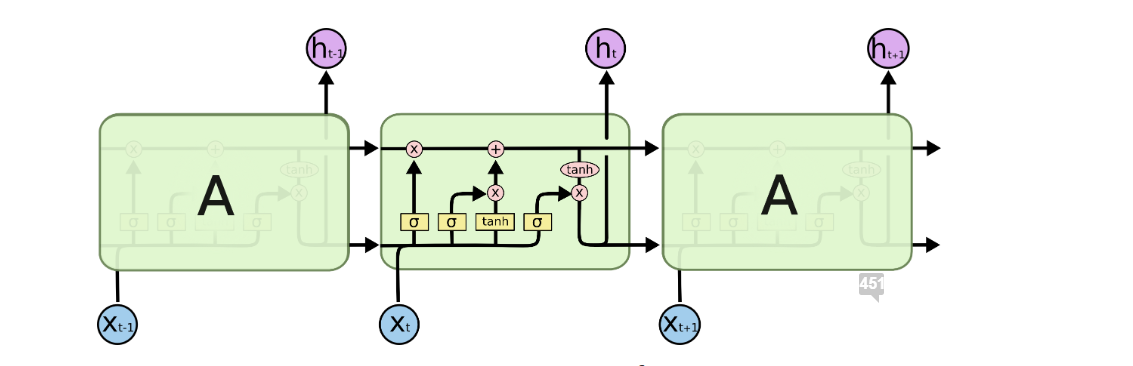]([https://](https://colah.github.io/posts/2015-08-Understanding-LSTMs/))

LSTM comes from long-short term memory, and is a type of recurrent neural network to handle long-range dependencies in sequential data. 

Let's start preparing a new embedding and then building the model with the functional API.

In [131]:

# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(10)

model_2_embedding = Embedding(input_dim=max_vocab_lenght,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     name="embedding_2")

In [132]:
from tensorflow.keras.layers import LSTM

# 1.Create the model ( Model 2 : LSTM Model)
inputs = Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
x = LSTM(64)(x) # return vector for whole sequence
outputs = Dense(1, activation="sigmoid")(x)
model_2 = Model(inputs, outputs, name="model_2_LSTM")

In [133]:
model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_2            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

For our LSTM, we have some extra parameters. This number comes from : 
> num_params = [(num_units + input_dim + 1) * num_units] * 4
>
Being the input dimension 128.


In [134]:
# 2. Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [135]:
# 3.Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.6524 - loss: 0.6021 - val_accuracy: 0.8247 - val_loss: 0.4134
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8578 - loss: 0.3419 - val_accuracy: 0.8076 - val_loss: 0.4484
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9170 - loss: 0.2284 - val_accuracy: 0.7853 - val_loss: 0.5204
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9456 - loss: 0.1615 - val_accuracy: 0.7800 - val_loss: 0.5537
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9622 - loss: 0.1173 - val_accuracy: 0.7774 - val_loss: 0.7521


The training accuracy has increased to great values while the validation accuracy looks it got a bit stale. Let's save the results.

#### Saving model 2 ( LSTM ) results

In [136]:
model_2_pred_probs = model_2.predict(val_sentences)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [138]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))

In [139]:
# Calculate model_2 metrics
model_2_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.74130006565989,
 'precision': 0.7760300818663501,
 'recall': 0.7774130006565988,
 'f1': 0.7749591082547599}

In [257]:
modelgraph.CompareModelScores(baseline_results, 
                                model_2_results)

Baseline accuracy: 81.88, New accuracy: 77.74, Difference: -4.14
Baseline precision: 0.83, New precision: 0.78, Difference: -0.05
Baseline recall: 0.82, New recall: 0.78, Difference: -0.04
Baseline f1: 0.81, New f1: 0.77, Difference: -0.04


### Model 3: GRU

Our new model will use a GRU layer, a type of recurrent neural network (RNN) layer designed to handle sequential data efficiently while addressing the vanishing gradient problem. It is similar to an LSTM but with a simpler structure, making it computationally less expensive.

[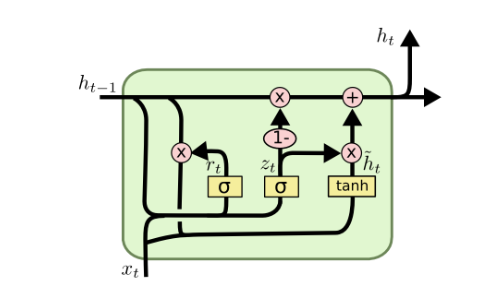]([https://](https://colah.github.io/posts/2015-08-Understanding-LSTMs/))

We will build it also using the application API and adding the [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) layer from tensorflow.

In [141]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(10)
model_3_embedding = layers.Embedding(input_dim=max_vocab_lenght,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     name="embedding_3")

In [ ]:

# 1. Build the model

from tensorflow.keras.layers import GRU


inputs = Input(shape=(1,), dtype="string")
x = text_vectorizer_2(inputs)
x = model_3_embedding(x)
x = GRU(64)(x) 
outputs = Dense(1, activation="sigmoid")(x)
model_3 = Model(inputs, outputs, name="model_3_GRU")

In [145]:
# 2. Compile the model

model_3.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])


In [146]:
model_3.summary()

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_2            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,317,313 (5.03 MB)

 Trainable params: 1,317,313 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [147]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.6292 - loss: 0.6267 - val_accuracy: 0.8168 - val_loss: 0.4146
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8539 - loss: 0.3607 - val_accuracy: 0.8109 - val_loss: 0.4330
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9085 - loss: 0.2366 - val_accuracy: 0.7866 - val_loss: 0.4768
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9423 - loss: 0.1693 - val_accuracy: 0.8004 - val_loss: 0.5654
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9563 - loss: 0.1343 - val_accuracy: 0.7820 - val_loss: 0.6618


#### Saving model 3 ( GRU ) results

Let's do the prediction and calculating the score steps and compare results at the end with our pandas table.

In [148]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))

# Calculate model_3 metrics
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


{'accuracy': 78.20091923834536,
 'precision': 0.7805887149795797,
 'recall': 0.7820091923834537,
 'f1': 0.7802811415403863}

In [259]:
modelgraph.CompareModelScores(baseline_results, 
                                model_3_results)

Baseline accuracy: 81.88, New accuracy: 78.20, Difference: -3.68
Baseline precision: 0.83, New precision: 0.78, Difference: -0.05
Baseline recall: 0.82, New recall: 0.78, Difference: -0.04
Baseline f1: 0.81, New f1: 0.78, Difference: -0.03


The GRU model has improved just a bit when compared to the LSTM model, even though GRU has certain improvements that has made it a more popular model and with normally better results.

We can see our base model still has the best accuracy and the model_1 the best F1 score. We are experimenting, so it is good to see what we can expect from different approaches.

### Model 4: Bidirectonal RNN model

This model will use the [bidirectional layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional), a type of recurrent neural network (RNN) layer that processes input sequences in both forward and backward directions. This allows the model to capture information from both past and future contexts, making it useful for tasks where context from both directions is important.

In [164]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(10)

model_4_embedding = Embedding(input_dim=max_vocab_lenght,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     name="embedding_4")


In [165]:
# 1. Build the model ( Bidirectional RNN )
from tensorflow.keras.layers import Bidirectional

inputs = Input(shape=(1,), dtype="string")
x = text_vectorizer_2(inputs)
x = model_4_embedding(x)
x = Bidirectional(LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = Dense(1, activation="sigmoid")(x)
model_4 = Model(inputs, outputs, name="model_4_Bidirectional")

In [167]:
# 2. Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

Let's confirm that our model looks as expected

In [168]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_3            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [169]:
# 3. Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.6513 - loss: 0.6005 - val_accuracy: 0.8135 - val_loss: 0.4170
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.8616 - loss: 0.3411 - val_accuracy: 0.8004 - val_loss: 0.4467
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.9212 - loss: 0.2143 - val_accuracy: 0.7754 - val_loss: 0.6337
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9558 - loss: 0.1373 - val_accuracy: 0.7879 - val_loss: 0.6687
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9573 - loss: 0.1170 - val_accuracy: 0.7892 - val_loss: 0.7345


#### Saving model 4 (BD LSTM) results

In [ ]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))

# Calculate model_6 metrics
model_4_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_4_preds)
model_4_results

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


{'accuracy': 78.92317793827971,
 'precision': 0.7895958794147182,
 'recall': 0.7892317793827971,
 'f1': 0.7854115108571392}

In [260]:
modelgraph.CompareModelScores(baseline_results, 
                                model_4_results)

Baseline accuracy: 81.88, New accuracy: 78.92, Difference: -2.95
Baseline precision: 0.83, New precision: 0.79, Difference: -0.04
Baseline recall: 0.82, New recall: 0.79, Difference: -0.03
Baseline f1: 0.81, New f1: 0.79, Difference: -0.03


### Model 5: 1 Dimension Convolutional NN

We have used CNN for classification problems with images as they are very effective detecting patters in 2 dimensions. Instead of applying 2D filters, 1D filters are applied sequentially.

They are good localizing specific combination of letter, but they lack sometimes when these words are far apart.

In [172]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(10)

model_5_embedding = Embedding(input_dim=max_vocab_lenght,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     name="embedding_5")

In [173]:
# 1. Create the model ( CNN 1D)
from tensorflow.keras.layers import Conv1D,GlobalMaxPool1D

inputs = Input(shape=(1,), dtype="string")
x = text_vectorizer_2(inputs)
x = model_5_embedding(x)
x = Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = GlobalMaxPool1D()(x)

outputs = Dense(1, activation="sigmoid")(x)
model_5 = Model(inputs, outputs, name="model_5_Conv1D")

In [174]:
# 2. Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [175]:
model_5.summary()

Model: "model_5_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_3            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 11, 32)         │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,300,545 (4.96 MB)

 Trainable params: 1,300,545 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

Our model is looking fine, let's train it and put it to test.

In [176]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.6326 - loss: 0.6389 - val_accuracy: 0.8155 - val_loss: 0.4434
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8376 - loss: 0.3939 - val_accuracy: 0.8162 - val_loss: 0.4230
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9129 - loss: 0.2363 - val_accuracy: 0.8011 - val_loss: 0.4802
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9525 - loss: 0.1470 - val_accuracy: 0.7892 - val_loss: 0.5373
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9687 - loss: 0.0982 - val_accuracy: 0.7965 - val_loss: 0.5836


#### Saving model 5 ( 1D CNN ) results

In [177]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))

# Calculate model_3 metrics
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


{'accuracy': 79.64543663821405,
 'precision': 0.7952849465919302,
 'recall': 0.7964543663821405,
 'f1': 0.7949804547617904}

In [261]:
modelgraph.CompareModelScores(baseline_results, 
                                model_5_results)

Baseline accuracy: 81.88, New accuracy: 79.65, Difference: -2.23
Baseline precision: 0.83, New precision: 0.80, Difference: -0.03
Baseline recall: 0.82, New recall: 0.80, Difference: -0.02
Baseline f1: 0.81, New f1: 0.79, Difference: -0.02


### Model 6: Transfer learning model

Just as we did in the transfer learning module, it is possible to fetch other models that have been previously trained for similar task and take advantage from how they have had access to larger datasets.

In [29]:
# Load tensorflow hub and layers to build the new TL model
# Load tf_keras as tensorflow hub has some compatibility problems
# with tensorflow.keras
import tensorflow_hub as hub
import tf_keras as keras

In [30]:
# Load the path for the model we want.
uni_encoder_path = "https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2"

In [ ]:
version_fn = getattr(tf.keras, "version", None)
print("TF Version: " + tf.__version__)
print("TF Keras Version: " + version_fn())
print("TF Hub version " + hub.__version__)

TF Version: 2.18.0
TF Keras Version: 3.8.0
TF Hub version 0.16.1


In [31]:
uni_encoder_layer = hub.KerasLayer(uni_encoder_path,
                   trainable=False,
                   dtype=tf.string,
                   name="uniencoder_model",
                   input_shape=[])

In [32]:
# 1. Create model using the Sequential API

model_6 = keras.Sequential([
  uni_encoder_layer, # take in sentences and then encode them into an embedding
  keras.layers.Dense(64, activation="relu"),
  keras.layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

In [33]:
# 2.Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 uniencoder_model (KerasLay  (None, 512)               256797824 
 er)                                                             
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [34]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5


I0000 00:00:1740474149.767951    2495 service.cc:148] XLA service 0x7fefadc4b270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740474149.768696    2495 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 with Max-Q Design, Compute Capability 7.5
2025-02-25 11:02:29.791279: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740474149.830965    2495 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1740474149.945934    2495 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


191/191 [==============================] - 12s 35ms/step - loss: 0.5272 - accuracy: 0.7719 - val_loss: 0.4348 - val_accuracy: 0.8142
Epoch 2/5
191/191 [==============================] - 6s 31ms/step - loss: 0.4205 - accuracy: 0.8126 - val_loss: 0.4195 - val_accuracy: 0.8234
Epoch 3/5
191/191 [==============================] - 7s 36ms/step - loss: 0.4048 - accuracy: 0.8220 - val_loss: 0.4184 - val_accuracy: 0.8201
Epoch 4/5
191/191 [==============================] - 7s 34ms/step - loss: 0.3960 - accuracy: 0.8268 - val_loss: 0.4156 - val_accuracy: 0.8221
Epoch 5/5
191/191 [==============================] - 7s 37ms/step - loss: 0.3890 - accuracy: 0.8307 - val_loss: 0.4175 - val_accuracy: 0.8267


#### Saving our TF model results

In [56]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))

# Calculate model_6 metrics
model_6_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_6_preds)
model_6_results

48/48 [==============================] - 1s 28ms/step


{'accuracy': 82.66579120157583,
 'precision': 0.8284080175185236,
 'recall': 0.8266579120157583,
 'f1': 0.8237104685795164}

In [262]:
modelgraph.CompareModelScores(baseline_results, 
                                model_6_results)

Baseline accuracy: 81.88, New accuracy: 82.47, Difference: 0.59
Baseline precision: 0.83, New precision: 0.83, Difference: 0.00
Baseline recall: 0.82, New recall: 0.82, Difference: 0.01
Baseline f1: 0.81, New f1: 0.82, Difference: 0.01


### Model Comparison

In [263]:
# Combine model results into a DataFrame
all_model_metrics = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results})
all_model_metrics = all_model_metrics.transpose()
all_model_metrics

,accuracy,precision,recall,f1
baseline,81.877873,0.825780,0.818779,0.813437
simple_dense,81.812213,0.817850,0.818122,0.816117
lstm,77.741300,0.776030,0.777413,0.774959
gru,78.200919,0.780589,0.782009,0.780281
bidirectional,78.923178,0.789596,0.789232,0.785412
conv1d,79.645437,0.795285,0.796454,0.794980
tf_hub_sentence_encoder,82.468812,0.826116,0.824688,0.821823


In [264]:
# Reduce the accuracy to same scale as other metrics
all_model_metrics["accuracy"] = all_model_metrics["accuracy"]/100

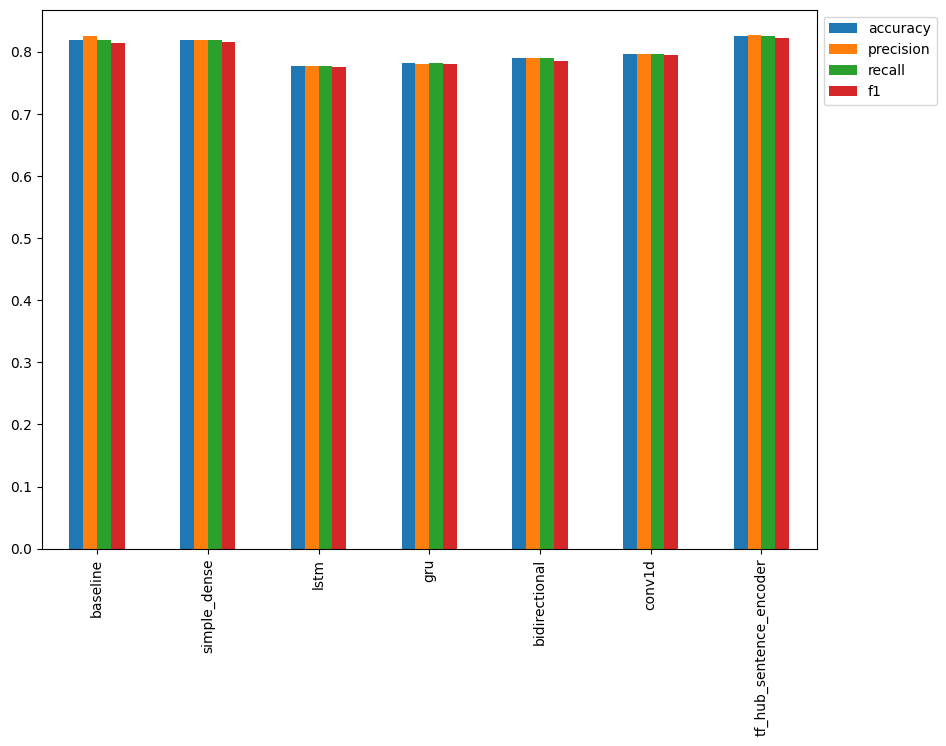

In [265]:
# Plot and compare all of the model results
all_model_metrics.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

### Saving and loading models

There are few problems saving and loading models that uses tensorflow hub and keras, so this will be updated later on ! 

For saving a model that used keras, this function can be used. Problems will arise later when loading, so this is not usable at the moment.

In [40]:
keras.saving.save_model(model_6, 'saved_models/model_6_uniencoder.keras', overwrite=True)

Now, loading back the model to use it again without having to train it:

In [21]:
import tensorflow_hub as hub
import tf_keras as keras
version_fn = getattr(tf.keras, "version", None)
print("TF Version: " + tf.__version__)
print("TF Keras Version: " + version_fn())
print("TF Hub version " + hub.__version__)

TF Version: 2.18.0
TF Keras Version: 3.8.0
TF Hub version 0.16.1


In [ ]:
#loaded_model = keras.saving.load_model('saved_models/model_6_uniencoder.keras')
# We would use for tensorflow 
# loaded_model = tf.keras.models.load_model('saved_models/model_6_uniencoder.keras')

### Visualizing the results

It is good to inspect the data and see how our model has performed and also, check how our model would perform in a real environment later with the test set.

It is important to see when our model do things right, how it is classifying but also more important, when it does thing wrong, think why the algorithm has processed it in that way and how could we imrpove the result.

In [47]:

# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,Get that hazard pay,0,0.0,0.140639
1,Roof collapsed a bowling alley many in the com...,1,0.0,0.206583
2,@colinhoffman29 I hope he does. And I hope you...,1,0.0,0.233301
3,After a Few Years Afloat Pension Plans Start S...,1,0.0,0.117131
4,Being able to stay out of work this week to ta...,0,0.0,0.145191


Let's find then the worst examples we have for false positives, meaning we got a disaster classification while they were not.

In [53]:
# Find the wrong predictions and sort by prediction probabilities
wrong_results = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
wrong_results[:10]

,text,target,pred,pred_prob
1334,Teen Disaster Preparedness Event in Van Nuys A...,0,1.0,0.968873
1048,Trusting Iran to stop terrorism is like inviti...,0,1.0,0.961823
970,Episcopal priests on road trip with interracia...,0,1.0,0.959557
353,HereÛªs how media in Pakistan covered the cap...,0,1.0,0.935747
803,Two Jewish Terrorists Charged In Historic-Chur...,0,1.0,0.920918
317,Burford. What a catastrophe! Traffic and big l...,0,1.0,0.918278
1514,Russian customs destroyed a total of 319 tons ...,0,1.0,0.911989
757,Truck Driver Salvages Banned Tomatoes From Des...,0,1.0,0.896270
349,if firefighters acted like cops they'd drive a...,0,1.0,0.888921
324,USW: 'The damage from abandoning the deal coul...,0,1.0,0.884591


For a better visualization of the text, lets print an iteration of different examples 

In [ ]:
# Check the false positives (model predicted 1 when should've been 0)
for row in wrong_results[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9688725471496582
Text:
Teen Disaster Preparedness Event in Van Nuys August 11 @ 5:30pm http://t.co/fXUX987vZx via @VanNuysCouncil

----

Target: 0, Pred: 1, Prob: 0.9618229269981384
Text:
Trusting Iran to stop terrorism is like inviting an arsonist to join the fire brigade - Telegraph http://t.co/2Z2HTDjQZD

----

Target: 0, Pred: 1, Prob: 0.9595573544502258
Text:
Episcopal priests on road trip with interracial family shares harrowing story of police harassment http://t.co/RG4JIsHyBs via @dailykos

----

Target: 0, Pred: 1, Prob: 0.9357474446296692
Text:
HereÛªs how media in Pakistan covered the capture of terrorist Mohammed Naved http://t.co/f7WqpCEkg2

----

Target: 0, Pred: 1, Prob: 0.9209181070327759
Text:
Two Jewish Terrorists Charged In Historic-Church Arson | The Ugly Truth http://t.co/iEksNFSbY7 http://t.co/VWCf3slkrW

----

Target: 0, Pred: 1, Prob: 0.9182775020599365
Text:
Burford. What a catastrophe! Traffic and big lorries. No action as usual fr

We can understand some elements in these senteces that could be easily mistaken, such as "Teen Disaster Preparedness" when it refers to just a bit of funny caos at some event, and many of the other are only news headlines or opinions that don't really tell about an actual disatrous event.

Let's do the same for the false negatives:

In [55]:
# Check the false negatives (model predicted 1 when should've been 0)
for row in wrong_results[-10:].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06261031329631805
Text:
@NeanderRebel If you take the suit off him I wouldn't be surprised to hear this is the face that belonged to another democrat mass-murderer

----

Target: 1, Pred: 0, Prob: 0.06195814907550812
Text:
all that panicking made me tired ;__; i want to sleep in my bed

----

Target: 1, Pred: 0, Prob: 0.05778536945581436
Text:
Keep shape your shoes ??#Amazon #foot #adjust #shape #shoe Mini Shoe Tree Stretcher Shaper Width Extender Adjustable http://t.co/8cPcz2xoHb

----

Target: 1, Pred: 0, Prob: 0.052561111748218536
Text:
Aubrey really out here body-bagging Meek.

----

Target: 1, Pred: 0, Prob: 0.05162357538938522
Text:
Next May I'll be free...from school from obligations like family.... Best of all that damn curfew...

----

Target: 1, Pred: 0, Prob: 0.04579329118132591
Text:
@blakeshelton DON'T be a FART ??in a WINDSTORM.FOLLOW ME ALREADY. JEEZ.

----

Target: 1, Pred: 0, Prob: 0.04171671345829964
Text:
the sunset boys wreck my bed   ori

In my opinion, this dataset does not seem to be completely correct as the ground truth of the targets sometimes doesn't follow a clear depiction of what is an actual disastrous event and what is not. Some labels could be corrected that is for sure.

Let's still check some of the correct tags to see still that for the majority of them, our model suceeded targeting to the right disatrous events.

In [57]:
for i in range(3):
  random_pos = random.randint(0, len(model_6_preds))
  print(f"Text: {val_sentences[random_pos]} \n") 
  print(f"Prediction:{model_6_preds[random_pos]}\n")
  print(f"Truth:{val_labels[random_pos]}\n")
  print("---\n")

Text: self harm// I'm so angry please tag your scars on tumblr jesus christ i dont wanna get triggered 

Prediction:0.0

Truth:0

---

Text: Obama Declares Disaster for Typhoon-Devastated Saipan:  http://t.co/M6LvKXl9ii 

Prediction:1.0

Truth:1

---

Text: Abe's government made clear that grenades were not 'weapon.' 

Prediction:1.0

Truth:1

---



#### Predicts and views on the test dataset

Let's now get the predictions on the test datasets and see some results.

In [60]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 3)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 40ms/step
Pred: 1, Prob: 0.5787906646728516
Text:
Any other generation this would've been fatality  http://t.co/zcCtZM9f0o

----

1/1 [==============================] - 0s 56ms/step
Pred: 1, Prob: 0.8924493193626404
Text:
Accident cleared in #PaTurnpike on PATP EB between PA-18 and Cranberry slow back to #traffic http://t.co/SL0Oqn0Vyr

----

1/1 [==============================] - 0s 55ms/step
Pred: 0, Prob: 0.10636179894208908
Text:
Creating updating and delivering content in channel sales is not an easy task. @Seismicsoftware helps break it down: http://t.co/q4FLTG7tzT

----



We can see that the first sentence we catched wouldn't necessarily be a bad event, while the prediction leans more into be one, so that would be a possible false positive.

The other two seem to be correct, as one would be correctly classified as an event and the next one would not be. To test more effectively, we would need to work on the data, and try to add ourselves values to confirm how good this model is testing, similarly to what we did with the validation data.

Still, this is more an example of what it would look in real life, as when we get these messages online the do not come with a flag for every type of idea or identification, so it is a way to confirm with retrospective how good is our model actually performing against fresh and new data.